In [1]:
import os
import cv2
import collections
import time
import tqdm
from PIL import Image
from functools import partial
train_on_gpu = True

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import torchvision
import torchvision.transforms as transforms
import torch
from torch.utils.data import TensorDataset, DataLoader,Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

import albumentations as albu

from catalyst.data import Augmentor
from catalyst.dl import utils
from catalyst.data.reader import ImageReader, ScalarReader, ReaderCompose, LambdaReader
from catalyst.dl.runner import SupervisedRunner
from catalyst.contrib.models.segmentation import Unet
from catalyst.dl.callbacks import DiceCallback, EarlyStoppingCallback, InferCallback, CheckpointCallback

import segmentation_models_pytorch as smp

In [2]:
def get_img(x, folder: str = 'train_images'):
    """
    Return image based on image name and folder.
    根据image的名字和文件夹返回RGB图片
    """
    data_folder = f"{path}/{folder}"
    image_path = os.path.join(data_folder, x)
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

#将训练集内的rle图片重新编写为带mask的图片直接在原图上进行修改,将mask区域改为1
def rle_decode(mask_rle: str = '', shape: tuple = (1400, 2100)):
    '''
    将rle编码解析为带mask的图像.

    :param mask_rle: 输入的带分割位置的str类型字串
    :param shape: 返回的图片形状
    返回值：mask标记为1 背景标记为0的numpy.array类型
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0::2], s[1::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape, order='F')

#为1400*2100的图片增加mask
def make_mask(df: pd.DataFrame, image_name: str = 'img.jpg', shape: tuple = (1400, 2100)):
    """
    将df中对应的img.jpg转化为带mask的四个类别的数组，shape1400*2100*4
    """
    encoded_masks = df.loc[df['im_id'] == image_name, 'EncodedPixels']
    masks = np.zeros((shape[0], shape[1], 4), dtype=np.float32)

    for idx, label in enumerate(encoded_masks.values):
        if label is not np.nan:
            mask = rle_decode(label)
            masks[:, :, idx] = mask

    return masks

def to_tensor(x, **kwargs):
    """
    Convert image or mask.
    将图片或者mask转化为通道数或图片数*长*宽的形式,输入为numpy.ndarray形式
    """
    return x.transpose(2, 0, 1).astype('float32')

#将带mask的图片转化为rle形式，也就是训练集输入的形式
def mask2rle(img):
    '''
    Convert mask to rle.
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    将mask转化为rle(即数据输入的形式)
    返回值：由像素起始位置构成的字串
    '''
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

#数据可视化
def visualize(image, mask, original_image=None, original_mask=None):
    """
    Plot image and masks.
    If two pairs of images and masks are passes, show both.
    """
    fontsize = 14
    class_dict = {0: 'Fish', 1: 'Flower', 2: 'Gravel', 3: 'Sugar'}

    if original_image is None and original_mask is None:
        f, ax = plt.subplots(1, 5, figsize=(24, 24))

        ax[0].imshow(image)
        for i in range(4):
            ax[i + 1].imshow(mask[:, :, i])
            ax[i + 1].set_title(f'Mask {class_dict[i]}', fontsize=fontsize)
    else:
        f, ax = plt.subplots(2, 5, figsize=(24, 12))

        ax[0, 0].imshow(original_image)
        ax[0, 0].set_title('Original image', fontsize=fontsize)

        for i in range(4):
            ax[0, i + 1].imshow(original_mask[:, :, i])
            ax[0, i + 1].set_title(f'Original mask {class_dict[i]}', fontsize=fontsize)

        ax[1, 0].imshow(image)
        ax[1, 0].set_title('Transformed image', fontsize=fontsize)

        for i in range(4):
            ax[1, i + 1].imshow(mask[:, :, i])
            ax[1, i + 1].set_title(f'Transformed mask {class_dict[i]}', fontsize=fontsize)


def visualize_with_raw(image, mask, original_image=None, original_mask=None, raw_image=None, raw_mask=None):
    """
    Plot image and masks.
    If two pairs of images and masks are passes, show both.
    """
    fontsize = 14
    class_dict = {0: 'Fish', 1: 'Flower', 2: 'Gravel', 3: 'Sugar'}

    f, ax = plt.subplots(3, 5, figsize=(24, 12))

    ax[0, 0].imshow(original_image)
    ax[0, 0].set_title('Original image', fontsize=fontsize)

    for i in range(4):
        ax[0, i + 1].imshow(original_mask[:, :, i])
        ax[0, i + 1].set_title(f'Original mask {class_dict[i]}', fontsize=fontsize)

    ax[1, 0].imshow(raw_image)
    ax[1, 0].set_title('Original image', fontsize=fontsize)

    for i in range(4):
        ax[1, i + 1].imshow(raw_mask[:, :, i])
        ax[1, i + 1].set_title(f'Raw predicted mask {class_dict[i]}', fontsize=fontsize)

    ax[2, 0].imshow(image)
    ax[2, 0].set_title('Transformed image', fontsize=fontsize)

    for i in range(4):
        ax[2, i + 1].imshow(mask[:, :, i])
        ax[2, i + 1].set_title(f'Predicted mask with processing {class_dict[i]}', fontsize=fontsize)


def plot_with_augmentation(image, mask, augment):
    """
    Wrapper for `visualize` function.
    """
    augmented = augment(image=image, mask=mask)
    image_flipped = augmented['image']
    mask_flipped = augmented['mask']
    visualize(image_flipped, mask_flipped, original_image=image, original_mask=mask)


In [11]:
sigmoid = lambda x: 1 / (1 + np.exp(-x))


def post_process(probability, threshold, min_size):
    """
    Post processing of each predicted mask, components with lesser number of pixels
    than `min_size` are ignored
    """
    # don't remember where I saw it
    #cv2.threshold将图片根据是否超过threshold限定到1或0，[1]则返回图像
    mask = cv2.threshold(probability, threshold, 1, cv2.THRESH_BINARY)[1]
    #connectedComponents()返回连通域，component为mask形状大小的图片,对应有相应的标记,num_component
    num_component, component = cv2.connectedComponents(mask.astype(np.uint8))
    predictions = np.zeros((350, 525), np.float32)
    num = 0
    for c in range(1, num_component):
        p = (component == c)
        if p.sum() > min_size:
            predictions[p] = 1
            num += 1
    return predictions, num


def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),
        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=0.5, border_mode=0),
        albu.GridDistortion(p=0.5),
        albu.OpticalDistortion(p=0.5, distort_limit=2, shift_limit=0.5),
        albu.Resize(320, 640)
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.Resize(320, 640)
    ]
    return albu.Compose(test_transform)


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform

    Args:
        preprocessing_fn (callbale): data normalization function
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose

    """

    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)


def dice(img1, img2):
    img1 = np.asarray(img1).astype(np.bool)
    img2 = np.asarray(img2).astype(np.bool)

    intersection = np.logical_and(img1, img2)

    return 2. * intersection.sum() / (img1.sum() + img2.sum())

In [4]:
path='../../understandingclouds_data'
train = pd.read_csv(f'{path}/train.csv')
sub = pd.read_csv(f'{path}/sample_submission.csv')
train['label'] = train['Image_Label'].apply(lambda x: x.split('_')[1])
train['im_id'] = train['Image_Label'].apply(lambda x: x.split('_')[0])

sub['label'] = sub['Image_Label'].apply(lambda x: x.split('_')[1])
sub['im_id'] = sub['Image_Label'].apply(lambda x: x.split('_')[0])

id_mask_count = train.loc[train['EncodedPixels'].isnull() == False, 'Image_Label'].apply(lambda x: x.split('_')[0]).value_counts().\
reset_index().rename(columns={'index': 'img_id', 'Image_Label': 'count'})
train_ids, valid_ids = train_test_split(id_mask_count['img_id'].values, random_state=42, stratify=id_mask_count['count'], test_size=0.1)
test_ids = sub['Image_Label'].apply(lambda x: x.split('_')[0]).drop_duplicates().values

In [5]:
class CloudDataset(Dataset):
    def __init__(self, df: pd.DataFrame = None, datatype: str = 'train', img_ids: np.array = None,
                 transforms = albu.Compose([albu.HorizontalFlip(),to_tensor]),
                preprocessing=None):
        self.df = df
        if datatype != 'test':
            self.data_folder = f"{path}/train_images"
        else:
            self.data_folder = f"{path}/test_images"
        self.img_ids = img_ids
        self.transforms = transforms
        self.preprocessing = preprocessing

    def __getitem__(self, idx):
        image_name = self.img_ids[idx]
        mask = make_mask(self.df, image_name)
        image_path = os.path.join(self.data_folder, image_name)
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        augmented = self.transforms(image=img, mask=mask)
        img = augmented['image']
        mask = augmented['mask']
        if self.preprocessing:
            preprocessed = self.preprocessing(image=img, mask=mask)
            img = preprocessed['image']
            mask = preprocessed['mask']
        return img, mask

    def __len__(self):
        return len(self.img_ids)

In [6]:
ENCODER = 'resnet18'
ENCODER_WEIGHTS = 'imagenet'
DEVICE = 'cuda'

ACTIVATION = None
model = smp.Unet(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=4,
    activation=ACTIVATION,
)
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

if torch.cuda.is_available():
    model.cuda(0)
num_workers = 0
bs = 4
train_dataset = CloudDataset(df=train, datatype='train', img_ids=train_ids, transforms = get_training_augmentation(), preprocessing=get_preprocessing(preprocessing_fn))
valid_dataset = CloudDataset(df=train, datatype='valid', img_ids=valid_ids, transforms = get_validation_augmentation(), preprocessing=get_preprocessing(preprocessing_fn))

train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True, num_workers=num_workers)
valid_loader = DataLoader(valid_dataset, batch_size=bs, shuffle=False, num_workers=num_workers)

loaders = {
    "train": train_loader,
    "valid": valid_loader
}

num_epochs = 1
logdir = "./logs/segmentation"

# model, criterion, optimizer
optimizer = torch.optim.Adam([
    {'params': model.decoder.parameters(), 'lr': 1e-2},
    {'params': model.encoder.parameters(), 'lr': 1e-3},
])
scheduler = ReduceLROnPlateau(optimizer, factor=0.15, patience=2)
criterion = smp.utils.losses.BCEDiceLoss(eps=1.)
runner = SupervisedRunner()

runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    loaders=loaders,
    callbacks=[DiceCallback(), EarlyStoppingCallback(patience=5, min_delta=0.001)],
    logdir=logdir,
    num_epochs=num_epochs,
    verbose=True
)


/home/billshen/.conda/envs/ml/lib/python3.6/site-packages/albumentations/augmentations/transforms.py:2874: UserWarning:

Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().



<IPython.core.display.Javascript object>

0/1 * Epoch (train): 100% 1248/1248 [11:45<00:00,  1.77it/s, _timers/_fps=10.590, dice=0.183, loss=1.039]
0/1 * Epoch (valid): 100% 139/139 [00:54<00:00,  2.54it/s, _timers/_fps=18.518, dice=0.296, loss=1.003]
[2019-10-18 20:14:32,043] 
0/1 * Epoch 0 (train): _base/lr=0.0010 | _base/momentum=0.9000 | _timers/_fps=8.9578 | _timers/batch_time=0.4514 | _timers/data_time=0.4464 | _timers/model_time=0.0050 | dice=0.3425 | loss=1.0230
0/1 * Epoch 0 (valid): _base/lr=0.0010 | _base/momentum=0.9000 | _timers/_fps=13.8129 | _timers/batch_time=0.2944 | _timers/data_time=0.2907 | _timers/model_time=0.0037 | dice=0.4256 | loss=0.9417
Top best models:
logs/segmentation/checkpoints//train.0.pth	0.9417


In [7]:
encoded_pixels = []
loaders = {"infer": valid_loader}
runner.infer(
    model=model,
    loaders=loaders,
    callbacks=[
        CheckpointCallback(
            resume=f"{logdir}/checkpoints/best.pth"),
        InferCallback()
    ],
)
valid_masks = []
probabilities = np.zeros((2220, 350, 525))
for i, (batch, output) in enumerate(tqdm.tqdm(zip(
        valid_dataset, runner.callbacks[0].predictions["logits"]))):
    image, mask = batch
    for m in mask:
        if m.shape != (350, 525):
            m = cv2.resize(m, dsize=(525, 350), interpolation=cv2.INTER_LINEAR)
        valid_masks.append(m)

    for j, probability in enumerate(output):
        if probability.shape != (350, 525):
            probability = cv2.resize(probability, dsize=(525, 350), interpolation=cv2.INTER_LINEAR)
        probabilities[i * 4 + j, :, :] = probability

class_params = {}


=> loading checkpoint ./logs/segmentation/checkpoints/best.pth
loaded checkpoint ./logs/segmentation/checkpoints/best.pth (epoch 0)


2it [00:00, 17.93it/s]

Top best models:



555it [00:32, 17.09it/s]


0
    threshold  size      dice
50       0.50     0  0.535135
75       0.75     0  0.535135
73       0.70  5000  0.535135
72       0.70  1200  0.535135
71       0.70   100  0.535135
1
    threshold   size      dice
84       0.80  10000  0.666695
89       0.85  10000  0.651078
88       0.85   5000  0.643643
83       0.80   5000  0.641058
87       0.85   1200  0.630452
2
    threshold   size      dice
64       0.60  10000  0.542691
69       0.65  10000  0.536833
74       0.70  10000  0.535655
59       0.55  10000  0.534495
79       0.75  10000  0.526356
3
    threshold   size      dice
49       0.45  10000  0.554806
44       0.40  10000  0.554641
59       0.55  10000  0.552599
54       0.50  10000  0.550869
64       0.60  10000  0.548427


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


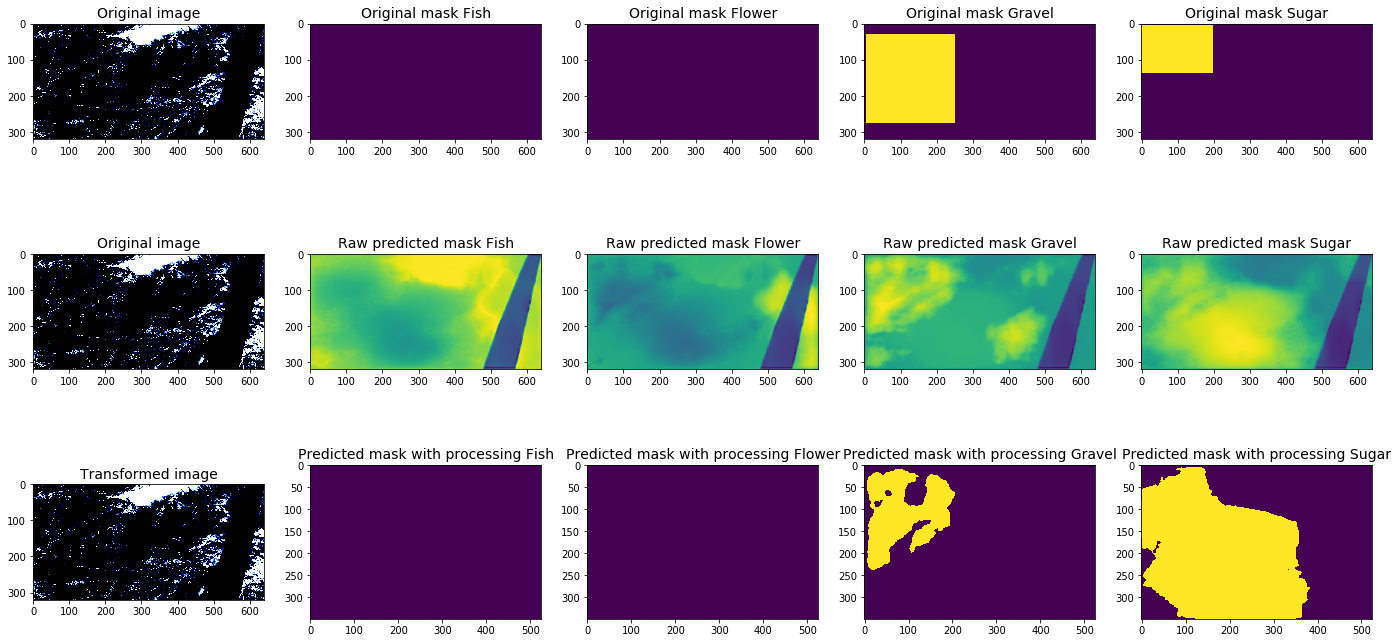

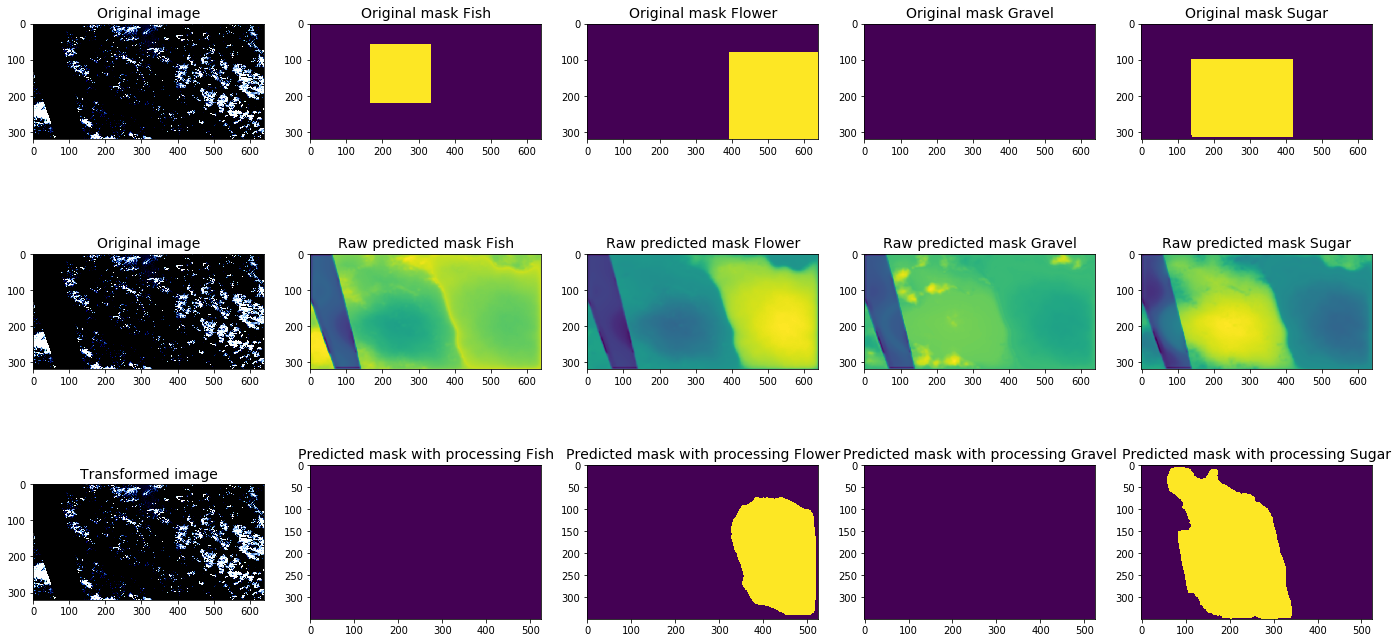

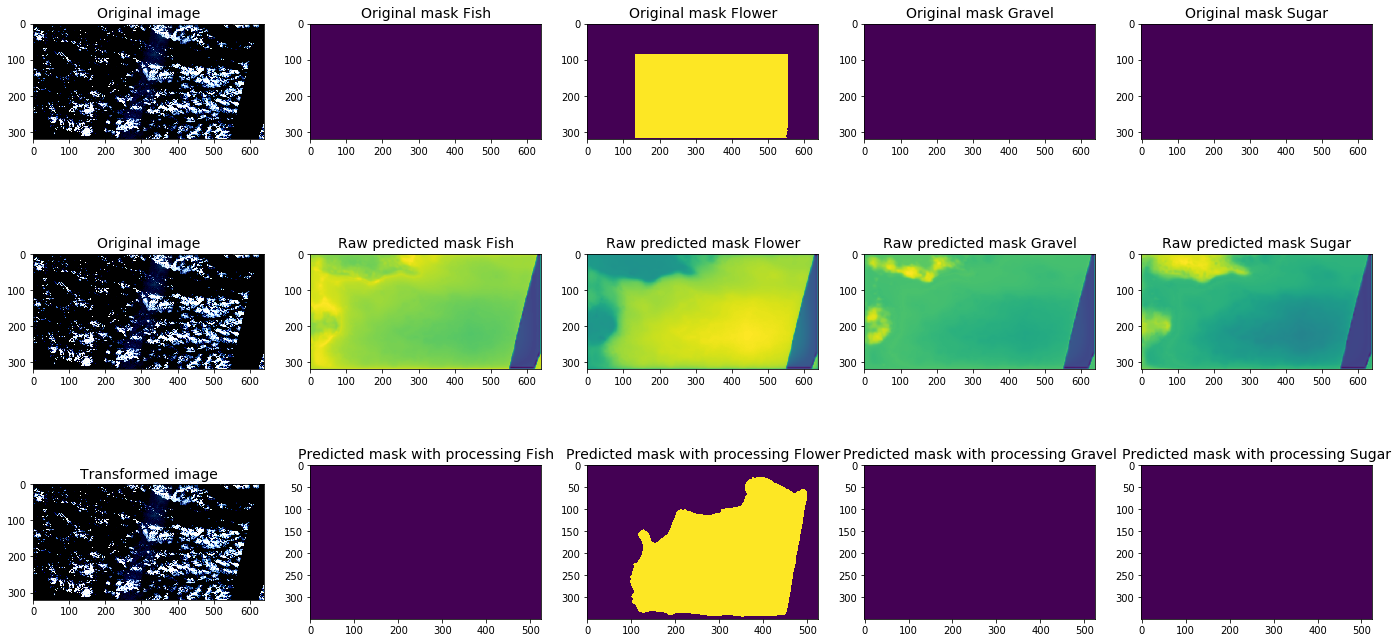

In [12]:
class_params = {}
for class_id in range(4):
    print(class_id)
    attempts = []
    for t in range(0, 100, 5):
        t /= 100
        for ms in [0, 100, 1200, 5000, 10000]:
            masks = []
            for i in range(class_id, len(probabilities), 4):
                probability = probabilities[i]
                predict, num_predict = post_process(sigmoid(probability), t, ms)
                masks.append(predict)

            d = []
            for i, j in zip(masks, valid_masks[class_id::4]):
                if (i.sum() == 0) & (j.sum() == 0):
                    d.append(1)
                else:
                    d.append(dice(i, j))

            attempts.append((t, ms, np.mean(d)))

    attempts_df = pd.DataFrame(attempts, columns=['threshold', 'size', 'dice'])


    attempts_df = attempts_df.sort_values('dice', ascending=False)
    print(attempts_df.head())
    best_threshold = attempts_df['threshold'].values[0]
    best_size = attempts_df['size'].values[0]
    
    class_params[class_id] = (best_threshold, best_size)

for i, (input, output) in enumerate(zip(
        valid_dataset, runner.callbacks[0].predictions["logits"])):
    image, mask = input

    image_vis = image.transpose(1, 2, 0)
    mask = mask.astype('uint8').transpose(1, 2, 0)
    pr_mask = np.zeros((350, 525, 4))
    for j in range(4):
        probability = cv2.resize(output.transpose(1, 2, 0)[:, :, j], dsize=(525, 350), interpolation=cv2.INTER_LINEAR)
        pr_mask[:, :, j], _ = post_process(sigmoid(probability), class_params[j][0], class_params[j][1])
    # pr_mask = (sigmoid(output) > best_threshold).astype('uint8').transpose(1, 2, 0)

    visualize_with_raw(image=image_vis, mask=pr_mask, original_image=image_vis, original_mask=mask, raw_image=image_vis,
                       raw_mask=output.transpose(1, 2, 0))

    if i >= 2:
        break

In [13]:
import gc
torch.cuda.empty_cache()
gc.collect()

test_dataset = CloudDataset(df=sub, datatype='test', img_ids=test_ids, transforms = get_validation_augmentation(), preprocessing=get_preprocessing(preprocessing_fn))
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=0)

loaders = {"test": test_loader}

encoded_pixels = []
image_id = 0
for i, test_batch in enumerate(tqdm.tqdm(loaders['test'])):
    runner_out = runner.predict_batch({"features": test_batch[0].cuda()})['logits']
    for i, batch in enumerate(runner_out):
        for probability in batch:

            probability = probability.cpu().detach().numpy()
            if probability.shape != (350, 525):
                probability = cv2.resize(probability, dsize=(525, 350), interpolation=cv2.INTER_LINEAR)
            predict, num_predict = post_process(sigmoid(probability), class_params[image_id % 4][0],
                                                class_params[image_id % 4][1])
            if num_predict == 0:
                encoded_pixels.append('')
            else:
                r = mask2rle(predict)
                encoded_pixels.append(r)
            image_id += 1
sub['EncodedPixels'] = encoded_pixels
sub.to_csv('submission.csv', columns=['Image_Label', 'EncodedPixels'], index=False)

 25%|██▍       | 227/925 [01:35<04:37,  2.51it/s]/home/billshen/.conda/envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning:

overflow encountered in exp

100%|██████████| 925/925 [06:26<00:00,  2.39it/s]
